In [1]:
import numpy as np
import pennylane as qml
import random
import torch
import itertools
import scipy.stats
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from qiskit.quantum_info import random_clifford

C:\Users\Public\New folder\envs\QML\Lib\site-packages\pennylane\capture\capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.4.33 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [2]:
n_qubits = 4

edges_by_k = {
    1: [],
    2: [(0, 1)],
    3: [(0, 1), (2, 3)],
    4: [(0, 1), (0, 2)],
    5: [(0, 1), (0, 2), (2, 3)],
    6: [(0, 1), (0, 2), (0, 3)],
}
permutations = list(itertools.permutations(range(n_qubits)))
states_by_k = {}

for k, base_edges in edges_by_k.items():

    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev)
    def circuit(permutation):
        for q in permutation:
            qml.Hadamard(wires=q)
        for (a, b) in base_edges:
            qml.CZ(wires=[permutation[a], permutation[b]])
        return qml.state()

    states = [circuit(perm) for perm in permutations]
    states_by_k[k] = np.array(states, dtype=np.complex64)
    
states1, states2, states3, states4, states5, states6 = (states_by_k[k] for k in range(1, 7))
print(len(states1), len(states2), len(states3), len(states4), len(states5), len(states6))

24 24 24 24 24 24


In [3]:
def QuantumStateDataset(states1, states2, states3, states4, states5, states6, num_samples=70):
    data = []
    labels = []

    for _ in range(num_samples):
 
        for i in range(24):
            matrix1, matrix2, matrix3, matrix4 = generate_random_special_unitary(2), generate_random_special_unitary(2), generate_random_special_unitary(2), generate_random_special_unitary(2)
            combined_matrix_in1 = np.kron(matrix1, matrix2)
            combined_matrix_in2 = np.kron(combined_matrix_in1, matrix3)
            combined_matrix = np.kron(combined_matrix_in2, matrix4)
            first_state = states1[i]    # Class no. 1
            second_state = states2[i]   # Class no. 2
            third_state = states3[i]    # Class no. 3
            fourth_state = states4[i]   # Class no. 4
            fifth_state = states5[i]    # Class no. 5
            sixth_state = states6[i]    # Class no. 6
       
            random_complex = np.random.randn(16) + 1j * np.random.randn(16)
            norm_random_complex = np.linalg.norm(random_complex)
            random_complex_state = random_complex/ norm_random_complex
            
            zero_label_states = [(first_state, -1)]
            one_label_states = [(random_complex_state, 1)]

            if random.random() < 0.5:
                initial_state, label = random.choice(zero_label_states)
            else:
                initial_state, label = random.choice(one_label_states)
            resulting_state = np.dot(combined_matrix, initial_state)
            norm = np.linalg.norm(resulting_state)
            normalized_resulting_state = resulting_state / norm
            data.append(normalized_resulting_state)
            labels.append(label)
    return data, labels

def generate_random_special_unitary(n):
    """Generate a random n x n special unitary matrix (Haar distributed)."""
    matrix =  scipy.stats.unitary_group.rvs(n)
    det = np.linalg.det(matrix)
    # Normalize to make determinant exactly 1
    matrix /= det**(1/n)
    return matrix

class QuantumStateTorchDataset(Dataset):
    def __init__(self, states, labels):
        self.states = torch.tensor(states, dtype=torch.complex64)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.states[idx], self.labels[idx]

class RealOutputWrapper(torch.nn.Module):
    def __init__(self, qlayer):
        super().__init__()
        self.qlayer = qlayer

    def forward(self, x):
        q_out = self.qlayer(x)
        return q_out.real 

def accuracy(X, Y):
    predictions = torch.sign(X)
    acc = ((predictions+Y)**2)/4
    return acc


In [4]:
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)
def variational_circuit(weights, inputs):
    qml.templates.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), normalize=True)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2)), qml.expval(qml.PauliZ(3))]

@qml.qnode(dev)
def quantum_model(weights, inputs):
    return variational_circuit(weights, inputs)

In [5]:
X_train_o, y_train_o = QuantumStateDataset(states1, states2, states3, states4, states5, states6, num_samples=250)
X_test_o, y_test_o = QuantumStateDataset(states1, states2, states3, states4, states5, states6, num_samples=250)

X_train= np.array(X_train_o)
y_train = np.array(y_train_o)
y_train = y_train.reshape(-1,1)
X_test= np.array(X_test_o)
y_test = np.array(y_test_o)
y_test = y_test.reshape(-1,1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
#print(X_train, X_test, y_train, y_test)

(6000, 16) (6000, 16) (6000, 1) (6000, 1)


In [6]:
num_layers = 4
lr=0.001
weight_shapes = {"weights": (num_layers, n_qubits, 3)}
num_epochs = 300
batch_size = 10
batches = (X_train.shape[0]) // batch_size
batches_test = (X_test.shape[0]) // batch_size

train_dataset = QuantumStateTorchDataset(X_train, y_train)
test_dataset = QuantumStateTorchDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [7]:
qlayer = qml.qnn.TorchLayer(quantum_model, weight_shapes)
clayer1 = torch.nn.Linear(4, 250)
clayer2 = torch.nn.Linear(250, 50)
clayer3 = torch.nn.Linear(50, 1)
tanh = torch.nn.Tanh()
model = torch.nn.Sequential(RealOutputWrapper(qlayer) , clayer1, tanh, clayer2, tanh, clayer3, tanh)
opt = torch.optim.Adam(model.parameters(), lr=lr)
loss = torch.nn.MSELoss()

In [8]:
epoch_list = []
loss_list = []
train_acc_list = []
test_acc_list = []
train_auc_list=[]
test_auc_list=[]

In [9]:
for epoch in range(num_epochs):

    running_loss = 0

    for x, y in train_loader:
        opt.zero_grad()
        #print(model(x).shape)
        #print(y.shape)
        # print(model(x).dtype)
        # print(y.dtype)
        loss_evaluated = loss(model(x), y)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    loss_list.append(avg_loss.item())
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))
    if avg_loss <= 0.2:
        print(f"Stopping early at epoch {epoch + 1} (avg_loss ≤ 0.2)")
        break

Average loss over epoch 1: 1.0213
Average loss over epoch 2: 1.0029
Average loss over epoch 3: 0.9943
Average loss over epoch 4: 0.9405
Average loss over epoch 5: 0.7530
Average loss over epoch 6: 0.4725
Average loss over epoch 7: 0.3183
Average loss over epoch 8: 0.2746
Average loss over epoch 9: 0.2522
Average loss over epoch 10: 0.2345
Average loss over epoch 11: 0.2235
Average loss over epoch 12: 0.2114
Average loss over epoch 13: 0.2038
Average loss over epoch 14: 0.2001
Average loss over epoch 15: 0.1978
Stopping early at epoch 15 (avg_loss ≤ 0.2)


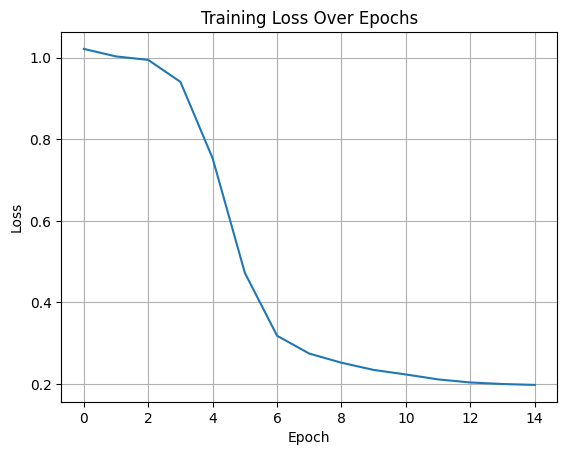

In [10]:
plt.plot(loss_list)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [11]:
running_loss=0
for x, y in train_loader:
        loss_evaluated = loss(model(x), y)
        running_loss += loss_evaluated
avg_loss = running_loss / batches
print("Average loss for training dataset",avg_loss)

running_acc=0
for x, y in train_loader:
        acc_evaluated = accuracy(model(x), y)
        running_acc += torch.mean(acc_evaluated) 
avg_acc = running_acc / batches
print("Accuracy for training dataset", avg_acc) 

Average loss for training dataset tensor(0.1867, grad_fn=<DivBackward0>)
Accuracy for training dataset tensor(0.9372, grad_fn=<DivBackward0>)


In [12]:
running_loss_test=0
for x, y in test_loader:
        loss_evaluated_test = loss(model(x), y)
        running_loss_test += loss_evaluated_test
avg_loss_test = running_loss_test / batches_test
print(batches_test)
print("Average loss for test dataset", avg_loss_test)

running_acc_test=0
for x, y in test_loader:
        acc_evaluated_test = accuracy(model(x), y)
        running_acc_test += torch.mean(acc_evaluated_test)
avg_acc_test = running_acc_test / batches_test
print("Accuracy for test dataset",avg_acc_test)

600
Average loss for test dataset tensor(0.2352, grad_fn=<DivBackward0>)
Accuracy for test dataset tensor(0.9195, grad_fn=<DivBackward0>)
